In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score 
from sklearn.metrics import precision_score 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

In [2]:
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
        * (normalized_high - normalized_low) + normalized_low

In [3]:
df_raw = pd.read_csv('./Data_Processed_All_Contractors_Characteristics - Data(New).csv')

In [5]:
df_raw.shape

(5046, 92)

In [6]:
columns_list = list(df_raw.columns)
def find_index(name):
    index_num = columns_list.index(name)
    print(index_num)

In [7]:
df_raw.columns

Index(['Dealer ID', 'year', 'train_test', 'Register_spring', 'Register_summer',
       'Register_fall', 'Register_winter', 'Converted State-IL',
       'Converted State-IN', 'Converted State-KY', 'Converted State-LA',
       'Converted State-MI', 'Converted State-MO', 'Converted State-NC',
       'Converted State-NJ', 'Converted State-OH', 'Converted State-Others',
       'Converted State-PA', 'Converted State-SC', 'Converted State-TN',
       'Converted State-TX', 'employeebucket-NA', 'employeebucket-4~8',
       'employeebucket-<4', 'employeebucket->8', 'No. of Employees',
       'Sales between 0-99,999', 'Sales between 100,000-499,999',
       'Other Sales', 'Sales N/A', 'Currently offers Consumer Financing?_No',
       'Currently offers Consumer Financing?_Yes',
       'Currently offers Consumer Financing?_N/A', 'Over 10', 'Below 10',
       'No year info', 'Gibson 18.Column3', 'Nest.Column3',
       'Hitting Potential 16.Column3', 'JS 16.Column3', 'JS 17.Column3',
       'JS 18.Co

In [10]:
xy_list = ['train_test',
           #Geographical Data (D)
           'Converted State-IL','Converted State-IN','Converted State-KY', 'Converted State-LA','Converted State-MI',
           'Converted State-MO','Converted State-NC','Converted State-NJ','Converted State-OH','Converted State-Others',
           'Converted State-PA','Converted State-SC','Converted State-TN','Converted State-TX',
           #Sales Data (D)
           'Sales between 0-99,999','Sales between 100,000-499,999','Other Sales', 'Sales N/A',
           #Financing Data (D)
           'Currently offers Consumer Financing?_No','Currently offers Consumer Financing?_Yes',
           'Currently offers Consumer Financing?_N/A',
           #Years in Business (D)
           'Over 10','Below 10','No year info',
           #Brand Data (D)
           'brand_1','brand_2','brand_3','brand_4','brand_5','brand_6','brand_7','brand_8',
           #Rating Data (D)
           'Contractor Rating_A','Contractor Rating_B','Contractor Rating_C','Contractor Rating_U','Contractor Rating_nan',
           #Number of Employees (D)
           'employeebucket_-','employeebucket_3~6','employeebucket_<3','employeebucket_>6','employeebucket_nan',
           #Historical Data (N)
           'num_applications_1_year_after_register','num_applications_1_year_after_register_approval',
           #y (Classification)
           'applied_in_window_2nd_12months_or_not'    
]

In [29]:
df_raw_xy = df_raw.loc[:,xy_list]
df_raw_xy.shape

(5046, 46)

In [30]:
features = [i for i in xy_list if i not in ['applied_in_window_2nd_12months_or_not','train_test']]
categorical_feats = [i for i in xy_list if i not in ['num_applications_1_year_after_register',
                                                      'num_applications_1_year_after_register_approval',
                                                     'applied_in_window_2nd_12months_or_not','train_test']]
numerical_feats = ['num_applications_1_year_after_register','num_applications_1_year_after_register_approval']
df_raw_xy = df_raw_xy.loc[(df_raw_xy['num_applications_1_year_after_register'] != 'Not enough info')&
                         (df_raw_xy['num_applications_1_year_after_register_approval'] != 'Not enough info')&
                          (df_raw_xy['applied_in_window_2nd_12months_or_not'] != 'Not enough info')]

In [31]:
df_raw_xy.shape

(2426, 46)

In [36]:
df_raw_xy['applied_in_window_2nd_12months_or_not'] = df_raw_xy['applied_in_window_2nd_12months_or_not'].astype(int)
df_raw_xy['num_applications_1_year_after_register'] = df_raw_xy['num_applications_1_year_after_register'].astype(int)
df_raw_xy['num_applications_1_year_after_register_approval'] = df_raw_xy['num_applications_1_year_after_register_approval'].astype(int)
encode_numeric_range(df_raw_xy,'num_applications_1_year_after_register',0,1)
encode_numeric_range(df_raw_xy,'num_applications_1_year_after_register_approval',0,1)

In [47]:
x_train = df_raw_xy.loc[(df_raw_xy['train_test'] == 1)].iloc[:,:45].drop('train_test',axis=1).values
y_train = df_raw_xy.loc[(df_raw_xy['train_test'] == 1)].iloc[:,45].values
x_test = df_raw_xy.loc[(df_raw_xy['train_test'] == 0)].iloc[:,:45].drop('train_test',axis=1).values
y_test = df_raw_xy.loc[(df_raw_xy['train_test'] == 0)].iloc[:,45].values

In [49]:
def svm(x_train,y_train,x_test,y_test, kernel_name='rbf', c_base = 2, gamma_base = 2,grid_cv_num = 5):
    svc = SVC(kernel=kernel_name, class_weight = 'balanced',probability=True)
    c_range = np.logspace(-2,4,10,base=c_base)
    gamma_range = np.logspace(-2,4,10,base=gamma_base)
    param_grid = [{'kernel':[kernel_name],'C':c_range,'gamma':gamma_range}]
    grid = GridSearchCV(svc,param_grid,cv=grid_cv_num,n_jobs=-1,verbose=1)
    clf = grid.fit(x_train,y_train)
    print("Best: %f using %s" % (clf.best_score_,clf.best_params_))
    pred = clf.predict(x_test)
    pred_prob = clf.predict_proba(x_test)
    pred_prob = [i[1] for i in pred_prob]
    matrix = confusion_matrix(y_test, pred, labels=None, sample_weight=None)
    score = grid.score(x_test,y_test)
    print('accuracy:{}'.format(score))
    return pred,pred_prob,matrix

In [62]:
pred,pred_prob,matrix = svm(x_train,y_train,x_test,y_test,'linear')

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  1.1min finished


Best: 0.660816 using {'C': 16.0, 'gamma': 0.25, 'kernel': 'linear'}
accuracy:0.6850715746421268


In [51]:
def metrix_matrix(matrix):
    df_matrix=pd.DataFrame(matrix,columns=['pred_0','pred_1'],index=['actual_0','actual_1'])
    tn, fp, fn, tp=matrix.ravel()
    acc=(tp+tn)/(tp+tn+fp+fn)
    ppv=tp/(tp+fp)
    npv=tn/(tn+fn)
    tpr=tp/(tp+fn)
    tnr=tn/(tn+fp)
    summary_matrix=[acc,ppv,npv,tpr,tnr]
    df_summary=pd.DataFrame(summary_matrix,columns=['Value'],index=['Accuracy','PPV','NPV','Sensitivity','Specificity'])
    return df_matrix,df_summary

In [58]:
df_matrix,df_summary = metrix_matrix(matrix)

In [59]:
df_matrix

,pred_0,pred_1
actual_0,211,69
actual_1,85,124


In [60]:
df_summary

,Value
Accuracy,0.685072
PPV,0.642487
NPV,0.712838
Sensitivity,0.593301
Specificity,0.753571


In [54]:
contractor_id = df_raw.loc[(df_raw['num_applications_1_year_after_register'] != 'Not enough info')&
                         (df_raw['num_applications_1_year_after_register_approval'] != 'Not enough info')&
                          (df_raw['applied_in_window_2nd_12months_or_not'] != 'Not enough info')&(df_raw['train_test'] == 0),'Dealer ID']
actual = y_test
predicted_prob = np.array(pred_prob)
predicted= pred

In [55]:
def TP(columna,columnb):
    if columna==1 and columnb==1:
        x=1
    else:
        x=0
    return x

df_result=pd.DataFrame()
df_result["contractor_id"]=contractor_id
df_result["actual"]=actual
df_result["predicted"]=predicted
df_result["predicted_prob"]=predicted_prob
df_result=df_result.sort_values(by=["predicted_prob"],ascending=False)
df_result["Actual_Positive"]=df_result.apply(lambda x: TP(x["actual"],x["predicted"]),axis=1)
df_result["Cumulative_Positives"]=df_result["Actual_Positive"].cumsum()
total_positives=df_result["Actual_Positive"].sum()
df_result["Cumulative_Positives_percent"]=df_result["Cumulative_Positives"]/total_positives
df_result["Cumulative_Count"]=df_result["contractor_id"].expanding().count()/df_result["contractor_id"].count()

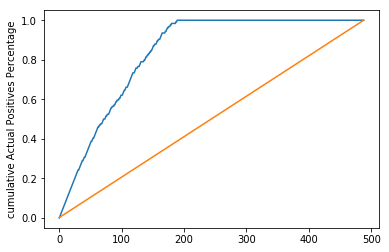

In [56]:
plt.plot(df_result["Cumulative_Positives_percent"].values.tolist())
plt.plot(df_result["Cumulative_Count"].values.tolist())
plt.ylabel('cumulative Actual Positives Percentage')

plt.show()

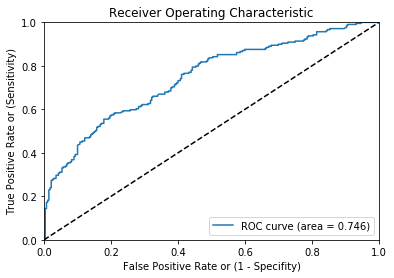

In [57]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(actual, predicted_prob,1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Boosted Tree

In [63]:
import lightgbm as lgb
from datetime import datetime
import warnings
import gc
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import seaborn as sns

In [156]:
df_raw_xy = df_raw.loc[:,xy_list]
df_raw_xy = df_raw_xy.loc[(df_raw_xy['num_applications_1_year_after_register'] != 'Not enough info')&
                         (df_raw_xy['num_applications_1_year_after_register_approval'] != 'Not enough info')&
                          (df_raw_xy['applied_in_window_2nd_12months_or_not'] != 'Not enough info')]
df_raw_xy['applied_in_window_2nd_12months_or_not'] = df_raw_xy['applied_in_window_2nd_12months_or_not'].astype(int)
df_raw_xy['num_applications_1_year_after_register'] = df_raw_xy['num_applications_1_year_after_register'].astype(int)
df_raw_xy['num_applications_1_year_after_register_approval'] = df_raw_xy['num_applications_1_year_after_register_approval'].astype(int)

encode_numeric_range(df_raw_xy,'num_applications_1_year_after_register',0,1)
encode_numeric_range(df_raw_xy,'num_applications_1_year_after_register_approval',0,1)

x_train = df_raw_xy.loc[(df_raw_xy['train_test'] == 1)].iloc[:,:45].drop('train_test',axis=1)
y_train = df_raw_xy.loc[(df_raw_xy['train_test'] == 1)].iloc[:,45]
x_test = df_raw_xy.loc[(df_raw_xy['train_test'] == 0)].iloc[:,:45].drop('train_test',axis=1)
y_test = df_raw_xy.loc[(df_raw_xy['train_test'] == 0)].iloc[:,45]

In [157]:
'''
set one function with different parameters to do parameters optimization
'''
def lgb_cv(num_leaves,
           min_data_in_leaf,
           max_depth,
           feature_fraction,
           bagging_fraction,
           lambda_l1,
          threshold):
    folds = KFold(n_splits=5, shuffle=True, random_state=15)
    oof = np.zeros(x_train.shape[0])
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train.values, y_train.values)):
        print("fold n°{}".format(fold_))
        trn_data = lgb.Dataset(x_train.iloc[trn_idx][features],
                               label=y_train.iloc[trn_idx],
                               categorical_feature=categorical_feats
                              )
        val_data = lgb.Dataset(x_train.iloc[val_idx][features],
                               label=y_train.iloc[val_idx],
                               categorical_feature=categorical_feats
                              )
        param = {
            'num_leaves': int(num_leaves),
            'min_data_in_leaf': int(min_data_in_leaf), 
            'objective':'binary',
            'max_depth': int(max_depth),
            'learning_rate': 0.05,
            "boosting": "gbdt",
            "feature_fraction": feature_fraction,
            "bagging_freq": 1,
            "bagging_fraction": bagging_fraction ,
            "bagging_seed": 11,
            "lambda_l1": lambda_l1,
            "verbosity": -1
        }
    
        clf = lgb.train(param,
                        trn_data,
                        10000,
                        valid_sets = [trn_data, val_data],
                        verbose_eval=500,
                        early_stopping_rounds = 200)
        
        oof[val_idx] = clf.predict(x_train.iloc[val_idx][features],
                                   num_iteration=clf.best_iteration)
        del clf, trn_idx, val_idx
        gc.collect()
    
    for i in range(x_train.shape[0]):
        if oof[i] >= threshold:
            oof[i] = 1
        else:
            oof[i] = 0

    return accuracy_score(oof, y_train.values)

In [158]:
'''
use bayesian optimization to find the optimal parameters in ranges
'''
LGB_BO = BayesianOptimization(lgb_cv, {
    'num_leaves': (5, 130),
    'min_data_in_leaf': (10, 150),
    'max_depth': (4, 10),
    'feature_fraction': (1,1),
    'bagging_fraction': (1,1),
    'lambda_l1': (0, 6),
    'threshold':(0.5,0.5),
    })

In [159]:
with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=2, n_iter=20, acq='ei', xi=0.0)

|   iter    |  target   | baggin... | featur... | lambda_l1 | max_depth | min_da... | num_le... | threshold |
-------------------------------------------------------------------------------------------------------------
fold n°0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.489024	valid_1's binary_logloss: 0.554118
fold n°1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[57]	training's binary_logloss: 0.501203	valid_1's binary_logloss: 0.553084
fold n°2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.469769	valid_1's binary_logloss: 0.519234
fold n°3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.486049	valid_1's binary_logloss: 0.549961
fold n°4
Training until validation scores don't

Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[199]	training's binary_logloss: 0.520481	valid_1's binary_logloss: 0.52669
fold n°3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.519129	valid_1's binary_logloss: 0.533503
fold n°4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[190]	training's binary_logloss: 0.515345	valid_1's binary_logloss: 0.546274
|  8        |  0.7352   |  1.0      |  1.0      |  5.962    |  9.724    |  148.4    |  127.1    |  0.5      |
fold n°0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[82]	training's binary_logloss: 0.495503	valid_1's binary_logloss: 0.553256
fold n°1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[66]	training's binary_logloss: 0.507105	valid_1's binary_

|  15       |  0.7383   |  1.0      |  1.0      |  5.692    |  9.954    |  82.78    |  127.7    |  0.5      |
fold n°0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[105]	training's binary_logloss: 0.514305	valid_1's binary_logloss: 0.551483
fold n°1
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[85]	training's binary_logloss: 0.520661	valid_1's binary_logloss: 0.548985
fold n°2
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[176]	training's binary_logloss: 0.516813	valid_1's binary_logloss: 0.524334
fold n°3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[136]	training's binary_logloss: 0.514798	valid_1's binary_logloss: 0.532247
fold n°4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[84]	training's binary_logloss: 0.519284	valid_1

In [160]:
'''
set parameters
'''
param = {
            'num_leaves': 63,
            'min_data_in_leaf': 52, 
            'objective':'binary',
            'max_depth': 4,
            'learning_rate': 0.05,
            "boosting": "gbdt",
            "feature_fraction": 1,
            "bagging_freq": 1,
            "bagging_fraction": 1,
            "bagging_seed": 11,
            "lambda_l1": 5.973,
            "verbosity": -1
        }

In [174]:
'''
run boosted tree
'''
folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof = np.zeros(len(x_train))
predictions = np.zeros(len(x_test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(x_train.values, y_train.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(x_train.iloc[trn_idx][features],
                           label=y_train.iloc[trn_idx],
                           categorical_feature=categorical_feats
                          )
    val_data = lgb.Dataset(x_train.iloc[val_idx][features],
                           label=y_train.iloc[val_idx],
                           categorical_feature=categorical_feats
                          )

    num_round = 10000
    clf = lgb.train(param,
                    trn_data,
                    num_round,
                    valid_sets = [trn_data, val_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200)
    
    oof[val_idx] = clf.predict(x_train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    
    predictions += clf.predict(x_test[features], num_iteration=clf.best_iteration) / folds.n_splits

pred_0_1 = [0]*len(predictions)
for i in range(x_train.shape[0]):
        if oof[i] >= 0.5:
            oof[i] = 1
        else:
            oof[i] = 0
for i in range(len(predictions)):
        if predictions[i] >= 0.477:
            pred_0_1[i] = 1
        else:
            pred_0_1[i] = 0
print("CV score: {:<8.5f}".format(accuracy_score(oof, y_train.values)))
print("Test Accuracy:{:<8.5f}".format(accuracy_score(pred_0_1, y_test.values)))

fold n°0
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[123]	training's binary_logloss: 0.5066	valid_1's binary_logloss: 0.550588
fold n°1


C:\Users\wuziy\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\wuziy\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')
C:\Users\wuziy\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\wuziy\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[61]	training's binary_logloss: 0.523558	valid_1's binary_logloss: 0.550409
fold n°2
Training until validation scores don't improve for 200 rounds.


C:\Users\wuziy\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\wuziy\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


Early stopping, best iteration is:
[177]	training's binary_logloss: 0.513416	valid_1's binary_logloss: 0.522508
fold n°3
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[169]	training's binary_logloss: 0.509832	valid_1's binary_logloss: 0.534486


C:\Users\wuziy\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\wuziy\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


fold n°4
Training until validation scores don't improve for 200 rounds.
Early stopping, best iteration is:
[118]	training's binary_logloss: 0.507824	valid_1's binary_logloss: 0.550307


C:\Users\wuziy\Anaconda3\lib\site-packages\lightgbm\basic.py:1186: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
C:\Users\wuziy\Anaconda3\lib\site-packages\lightgbm\basic.py:752: UserWarning: categorical_feature in param dict is overridden.
  warnings.warn('categorical_feature in param dict is overridden.')


CV score: 0.74084 
Test Accuracy:0.75869 


In [175]:
matrix = confusion_matrix(y_test.values, pred_0_1, labels=None, sample_weight=None)
df_matrix,df_summary = metrix_matrix(matrix)

In [176]:
df_matrix

,pred_0,pred_1
actual_0,236,44
actual_1,74,135


In [177]:
df_summary

,Value
Accuracy,0.758691
PPV,0.754190
NPV,0.761290
Sensitivity,0.645933
Specificity,0.842857


In [178]:
contractor_id = df_raw.loc[(df_raw['num_applications_1_year_after_register'] != 'Not enough info')&
                         (df_raw['num_applications_1_year_after_register_approval'] != 'Not enough info')&
                          (df_raw['applied_in_window_2nd_12months_or_not'] != 'Not enough info')&(df_raw['train_test'] == 0),'Dealer ID']
actual = y_test.values
predicted_prob = np.array(predictions)
predicted= pred_0_1

In [179]:
def TP(columna,columnb):
    if columna==1 and columnb==1:
        x=1
    else:
        x=0
    return x

df_result=pd.DataFrame()
df_result["contractor_id"]=contractor_id
df_result["actual"]=actual
df_result["predicted"]=predicted
df_result["predicted_prob"]=predicted_prob
df_result=df_result.sort_values(by=["predicted_prob"],ascending=False)
df_result["Actual_Positive"]=df_result.apply(lambda x: TP(x["actual"],x["predicted"]),axis=1)
df_result["Cumulative_Positives"]=df_result["Actual_Positive"].cumsum()
total_positives=df_result["Actual_Positive"].sum()
df_result["Cumulative_Positives_percent"]=df_result["Cumulative_Positives"]/total_positives
df_result["Cumulative_Count"]=df_result["contractor_id"].expanding().count()/df_result["contractor_id"].count()

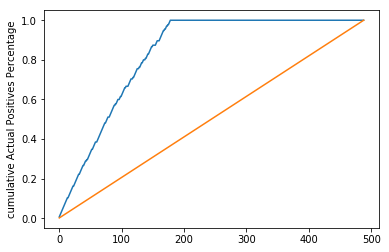

In [180]:
plt.plot(df_result["Cumulative_Positives_percent"].values.tolist())
plt.plot(df_result["Cumulative_Count"].values.tolist())
plt.ylabel('cumulative Actual Positives Percentage')

plt.show()

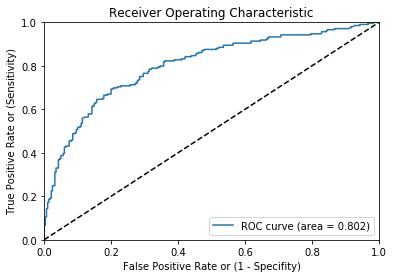

In [181]:
# Compute fpr, tpr, thresholds and roc auc
fpr, tpr, thresholds = roc_curve(actual, predicted_prob,1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

C:\Users\wuziy\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


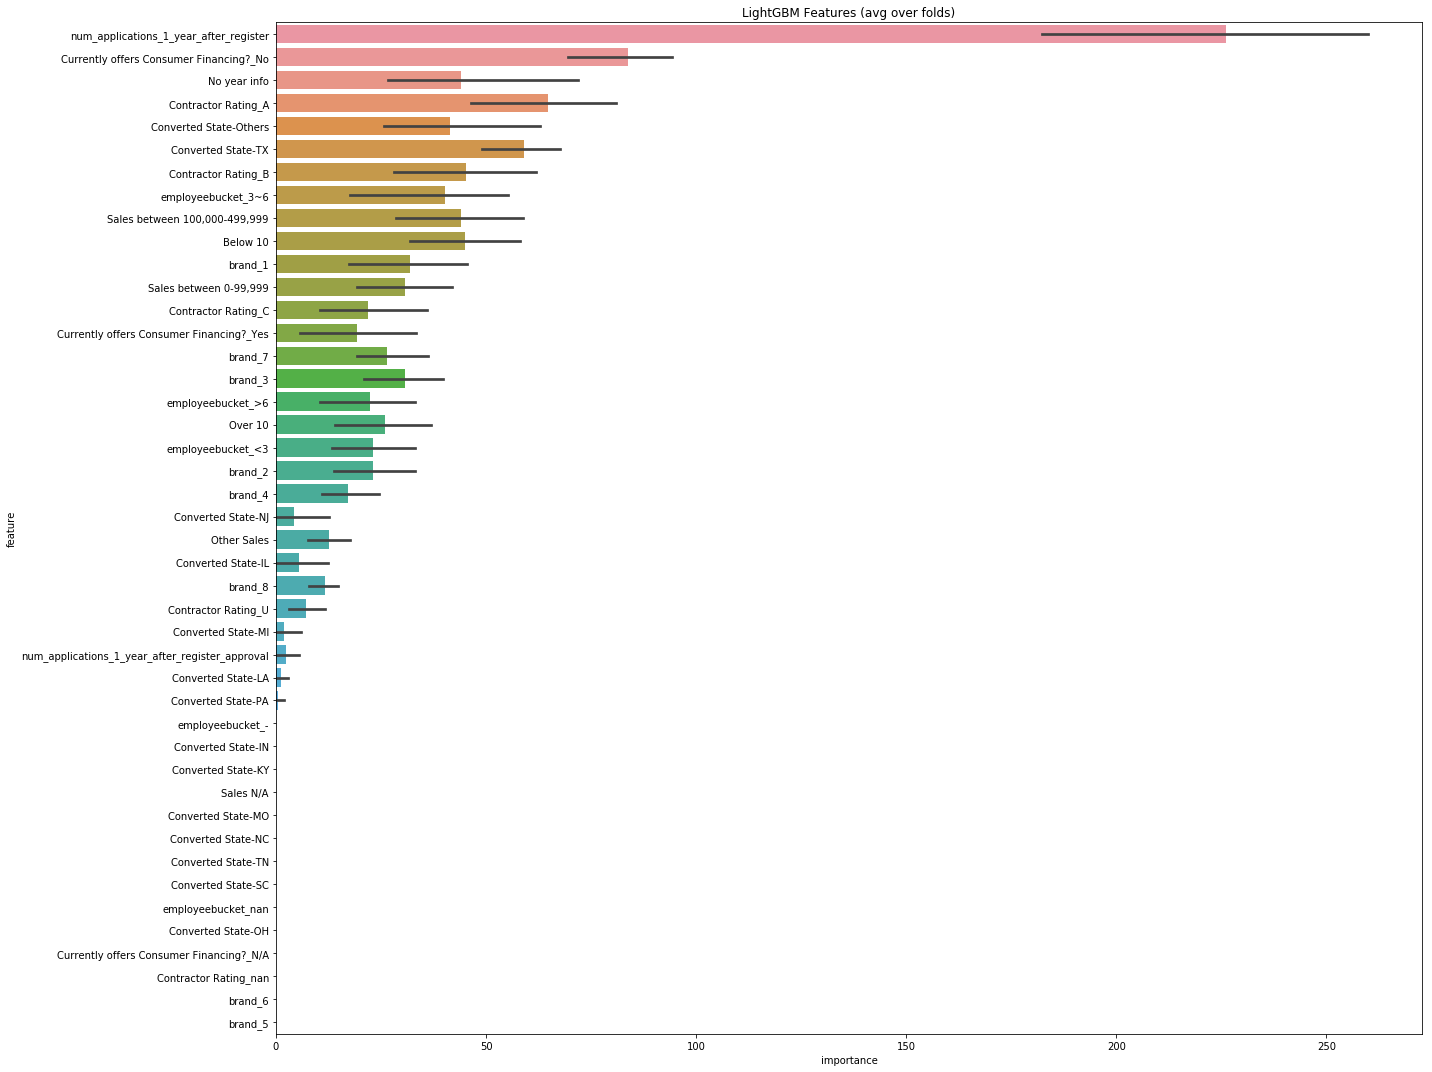

In [182]:
cols = (feature_importance_df[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:1000].index)

best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]

plt.figure(figsize=(20,15))
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('lgbm_importances.png')